# Libraries and Installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/M2_DataScience_Ikhlass/Applied Deep Learning/Projet/presentation
!ls

/content/drive/MyDrive/M2_DataScience_Ikhlass/Applied Deep Learning/Projet/presentation
 authorsName_to_id.pickle	     papersid_to_title.pickle
'Copie de GraphRecSys_final.ipynb'   Soutenance_notebook.ipynb
 data_pyg.pt			     test_data_pyg.pt
 dblp.json			     train_data_pyg.pt
 embeddings.npz			     vgae_gcn_h128_out32_relu.pt
 gae_2sage_h128_out32_relu.pt


In [3]:
import json
import pickle

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
#INSTALL TORCH GEOMETRIC
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git 
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

from torch_geometric.nn.models import InnerProductDecoder, VGAE
from torch_geometric.nn import GCNConv, GNNExplainer, SAGEConv

     |████████████████████████████████| 7.9 MB 5.6 MB/s 
     |████████████████████████████████| 3.5 MB 41.2 MB/s 


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load dblp dataset

In [6]:
dblp = []
with open('dblp.json', 'r') as json_file:
    dblp = json.load(json_file)

## Load authors and papers dict

In [7]:
with open('authorsName_to_id.pickle', 'rb') as f:
    authors_dict = pickle.load(f)

with open('papersid_to_title.pickle', 'rb') as f:
    papers_dict = pickle.load(f)

## Load titles and abstracts embedding

In [8]:
data = np.load('embeddings.npz')
abs_embeddings = data['abstracts_emb']
title_embeddings = data['title_emb']

# Visualizations

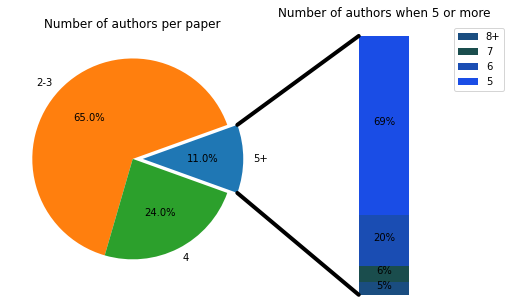

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

nb_authors = dict()
for i in range(len(dblp)):
  nb_authors[len(dblp[i]["authors"])] = nb_authors.get(len(dblp[i]["authors"]), 0) + 1

authors1 = round((nb_authors[2] + nb_authors[3])/len(dblp), 2)
authors2 = round(nb_authors[4]/len(dblp), 2)
authors3 = round(1 - authors1 - authors2, 2)

authors5 = len(dblp) - (nb_authors[2] + nb_authors[3] + nb_authors[4])

authors5_1 = round(nb_authors[5]/authors5, 2)
authors5_2 = round(nb_authors[6]/authors5, 2)
authors5_3 = round(nb_authors[7]/authors5, 2)
authors5_4 = round(1 - authors5_1 - authors5_2 - authors5_3, 2)

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [authors3, authors1, authors2]
labels = ['5+', '2-3', '4']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.set_title("Number of authors per paper")
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# bar chart parameters

xpos = 0
bottom = 0
ratios = [authors5_4, authors5_3, authors5_2, authors5_1]
width = .2
colors = [[.1, .3, .5], [.1, .3, .3], [.1, .3, .7], [.1, .3, .9]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Number of authors when 5 or more')
ax2.legend(('8+', '7', '6', '5'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

Text(0.5, 1.0, 'Number of references per paper')

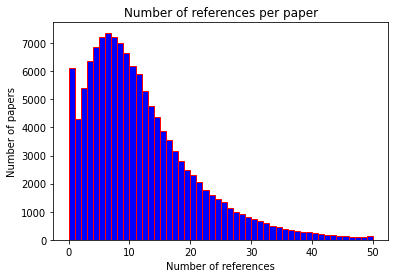

In [10]:
citations = list()
for i in range(len(dblp)):
  if dblp[i].get("references"):
    citations.append(len(dblp[i]["references"]))
  else:
    citations.append(0)
citations.sort()

plt.hist(citations, range = (0, 50), bins = 50, color = 'blue',
            edgecolor = 'red')
plt.ylabel('Number of papers')
plt.xlabel('Number of references')
plt.title('Number of references per paper')


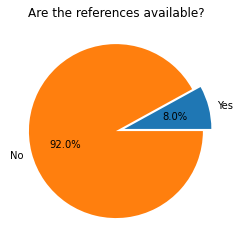

In [11]:
papers_available = set()
for i in range(len(dblp)):
  papers_available.add(dblp[i]["id"])

available = 0
non_available = 0
for i in range(len(dblp)):
  if dblp[i].get("references"):
    for reference in dblp[i]["references"]:
      if reference in papers_available:
        available += 1
      else:
        non_available += 1

tot_references = available + non_available
available = round(available / tot_references, 2)
non_available = round(non_available / tot_references, 2)

y = np.array([available, non_available])
mylabels = ["Yes", "No"]
myexplode = [0.1, 0]

plt.pie(y, labels = mylabels, explode = myexplode, autopct='%1.1f%%')
plt.title("Are the references available?")
plt.show()

# Graph models

## Build models

### GAE

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.sage1 = SAGEConv(data.num_node_features, 128)
        self.sage2 = SAGEConv(128, 32)
        self.lrelu = nn.LeakyReLU()

    def encode(self, data_pyg):
        x = self.sage1(data_pyg.x.float(), data_pyg.pos_edge_index) # convolution 1
        x = self.lrelu(x)
        x = self.sage2(x, data_pyg.pos_edge_index) # convolution 2
        return x

    def decode(self, z, edge_index): # only pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

### VGAE

In [13]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.gcn_shared = GCNConv(in_channels, hidden_channels)
        self.gcn_mu = GCNConv(hidden_channels, out_channels)
        self.gcn_logvar = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn_shared(x, edge_index))
        mu = self.gcn_mu(x, edge_index)
        logvar = self.gcn_logvar(x, edge_index)
        return mu, logvar

class DeepVGAE(VGAE):
    def __init__(self, gcn_encoder):
        super(DeepVGAE, self).__init__(encoder=gcn_encoder,
                                       decoder=InnerProductDecoder())

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        adj_pred = self.decoder.forward_all(z)
        return adj_pred

    def loss(self, x, all_edge_label, all_edge_index):
        pos_edge_index = all_edge_index[:, all_edge_label==1]
        neg_edge_index = all_edge_index[:, all_edge_label==0]

        z = self.encode(x, pos_edge_index)

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + 1e-15).mean()

        neg_loss = -torch.log(1 - self.decoder(z, neg_edge_index, sigmoid=True) + 1e-15).mean()

        kl_loss = 1 / x.size(0) * self.kl_loss()

        return pos_loss + neg_loss + kl_loss

    def single_test(self, x, train_pos_edge_index, test_pos_edge_index, test_neg_edge_index):
        with torch.no_grad():
            z = self.encode(x, train_pos_edge_index)
        roc_auc_score, average_precision_score = self.test(z, test_pos_edge_index, test_neg_edge_index)
        return roc_auc_score, average_precision_score

## Load Torch geometric dataset

In [14]:
data = torch.load('data_pyg.pt', map_location=device)
train_data = torch.load('train_data_pyg.pt', map_location=device)
test_data = torch.load('test_data_pyg.pt', map_location=device)

## Load models

In [15]:
gae = Net()
gae.load_state_dict(torch.load('gae_2sage_h128_out32_relu.pt'))
gae.to(device)


vgae = DeepVGAE(GCNEncoder(768, 128, 32))
vgae.load_state_dict(torch.load('vgae_gcn_h128_out32_relu.pt'))
vgae.to(device)
print('Models loaded')

Models loaded


# Recommmender systems

In [16]:
@torch.no_grad()
def recommend_gae(model, author_name, authors_name2id, papers_id2title):
    model.eval()
    
    authorid = authors_name2id[author_name]
    papers_nodes = (torch.arange(len(papers_id2title)) + len(authors_name2id)).view(1, -1)
    author_node = torch.full(papers_nodes.shape, authorid)
    curr_edge_index = torch.cat([author_node, papers_nodes], dim=0)

    z = model.encode(train_data) # encode train
    link_logits = model.decode(z, curr_edge_index) # decode current
    link_probs = link_logits.sigmoid() # apply sigmoid
    return link_logits

@torch.no_grad()
def recommend_vgae(model, author_name, authors_name2id, papers_id2title):
    model.eval()
    
    authorid = authors_name2id[author_name]
    papers_nodes = (torch.arange(len(papers_id2title)) + len(authors_name2id)).view(1, -1)
    author_node = torch.full(papers_nodes.shape, authorid)
    curr_edge_index = torch.cat([author_node, papers_nodes], dim=0)

    z = model.encode(data.x.to(device), curr_edge_index.to(device)) # encode train
    link_logits = model.decode(z, curr_edge_index) # decode test or val
    link_probs = link_logits.sigmoid() # apply sigmoid
    label_probs = [test_data.edge_label.cpu(), link_probs.cpu()]
    return link_logits

## Simple recommendation

Libraries needed to calculate cosine similarity, euclidean distance and dot product.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import numpy as np
import copy

Here, we create the papers embeddings.
The embeddings of a paper will be the concatenation of the embeddings of its abstract and its title.

In [18]:
papers_embeddings = [] # In this we will store the embeddings of the papers
for i in range(len(dblp)): # For each paper...
  papers_embeddings.append(np.hstack((abs_embeddings[i], title_embeddings[i]))) # ... we concatenate the embeddings of its abstract and its title

We create a function that uses 'papers_embeddings' to recommends 'number_of_papers' papers to 'name' based on the 'method'.

In [19]:
def papers_recommender(name, papers_embeddings, number_of_papers, method):

  author_embeddings = [] # In this we will store the embeddings of the author
  for i in range(len(dblp)): # We check each paper one by one
    if name in dblp[i]["authors"]: # If the author has written this paper...
      author_embeddings.append(papers_embeddings[i]) # ... we add to his embeddings the embeddings of the paper
  author_embeddings = [np.mean(k) for k in zip(*author_embeddings)] # Our final embeddings contains the mean of all the embeddings of its papers

  new_dblp = copy.deepcopy(dblp) # New variable so that we don't touch the original
  new_papers_embeddings = copy.deepcopy(papers_embeddings) # New variable so that we don't touch the original

  papers_to_del = [] # List that will contain the indexes of the papers that the author wrote
  for i in range(len(dblp)): # We check every paper
    if name in dblp[i]["authors"]: # If the author has written this paper...
      papers_to_del.append(i) # Then we add the index of this paper to the list of papers to delete
  papers_to_del.sort(reverse = True) # We class them in descending order so that it doesn't mess with the indexes
  for i in papers_to_del: # We loop inside the index of every paper that the author wrote
    new_dblp.pop(i) # We delete this paper
    new_papers_embeddings.pop(i) # We delete its embeddings

  recommendations = dict() # This dictionary will have the index of paper as key and the value of the method we use between the paper and the author as value
  for i in range(len(new_papers_embeddings)): # We loop into every paper that the author didn't write
    if method == "cosine similarity": # If we want to use cosine similarity
      recommendations[i] = float(cosine_similarity([new_papers_embeddings[i]], [author_embeddings])) # We append the cosine similarity to the dictionary
    elif method == "dot product": # If we want to use dot product
      recommendations[i] = np.dot(new_papers_embeddings[i], author_embeddings)
    else: # If we want to use euclidean distance
      recommendations[i] = distance.euclidean(new_papers_embeddings[i], author_embeddings)
  sort_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=sort_descending) # We create a list where we sort the values according to the method
  sort_indexes = list(list(zip(*sort_recommendations))[0]) # We create a list containing the indexes sorted according to the method
  sort_titles = [] # We create a list that will contain the titles sorted according to the method
  for i in range(number_of_papers): # We go through the numbers of papers we want to recommend...
    sort_titles.append(new_dblp[sort_indexes[i]]['title']) # ...and we add them to the list of titles
  return sort_titles

In the next cell, we execute the function to recommend the papers to a selected author using a selected method.

In [20]:
number_of_papers = 10 # The number of papers we want to recommend

name = input("Enter your name: ")
while name not in authors_dict.keys():
  name = input("You are not in the database. Please enter the name of someone else: ")

methods = ["cosine similarity", "dot product", "euclidean distance"]
method = input("Enter your method you want to use ('cosine similarity', 'dot product' or 'euclidean distance'): ")
while method not in methods:
  method = input("Please enter the name of another method ('cosine similarity', 'dot product' or 'euclidean distance'): ")

sort_descending = True # We want to maximize cosine similarity and dot product 
if method == "euclidean distance":
  sort_descending = False # We want to minimize euclidean distance 

paper_for_you = papers_recommender(name, papers_embeddings, number_of_papers, method)
papers_written = []
for i in range(len(dblp)):
  if name in dblp[i]["authors"]:
    papers_written.append(dblp[i]["title"])
print("You have written " + str(len(papers_written)) + " papers from our database:")
for i in range(len(papers_written)):
  print(str(i + 1) + " - " + papers_written[i])
print("Based on that, here are the " + str(number_of_papers) + " papers that we recommend you the most using " + method + ":")
for i in range(number_of_papers):
  print(str(i + 1) + " - " + paper_for_you[i])

Enter your name: Olivier Grisel
Enter your method you want to use ('cosine similarity', 'dot product' or 'euclidean distance'): euclidean distance
You have written 5 papers from our database:
1 - Principal Component Regression Predicts Functional Responses across Individuals
2 - API design for machine learning software: experiences from the scikit-learn project
3 - Scikit-learn: Machine Learning in Python
4 - Semi-supervised factored logistic regression for high-dimensional neuroimaging data
5 - Scikit-learn: Machine Learning Without Learning the Machinery
Based on that, here are the 10 papers that we recommend you the most using euclidean distance:
1 - The SHOGUN Machine Learning Toolbox
2 - Scale-invariant learning and convolutional networks
3 - Statistical Learning Theory: A Primer
4 - Making Early Predictions of the Accuracy of Machine Learning Applications
5 - Introduction to Semi-Supervised Learning
6 - Learning dynamic Bayesian network models via cross-validation
7 - Open scienc

## Recommendations using GAE

In [21]:
K = 10 # number of recommendations

### by decoding the GAE latent dim

In [22]:
recommendations = recommend_gae(gae, 'Olivier Grisel', authors_dict, papers_dict).topk(K)
for title, score in zip(recommendations.indices, recommendations.values) :
    print(f"{papers_dict[title]} - {score}\n")

Locally constrained active contour: a region-based level set for ovarian cancer metastasis segmentation - 5.320206642150879

3D/2D Registration Via Skeletal Near Projective Invariance in Tubular Objects - 5.161672592163086

A graph-with-loop structure for a topological representation of 3D objects - 5.146899223327637

A low complexity and robust frequency offset estimation algorithm for OFDM-Based WLAN systems - 5.11851692199707

3-D Angular Spectrum Measurements at 5 GHz in a Residential Two-Story House - 5.096289157867432

3D-2D registration based on mesh-derived image bisection - 5.087277412414551

A watermarking scheme based on discrete non-separable wavelet transform - 5.0563154220581055

Nonlinear elasto-mammography for characterization of breast tissue properties - 5.024839878082275

A robust hole-filling algorithm for triangular mesh - 5.022103309631348

Biometric Feature-Type Transformation: Making templates compatible for secret protection - 5.019630432128906



### by applying cosine similarity 

In [23]:
gae_embeddings = gae.encode(data)
author_gae_emb = gae_embeddings[authors_dict['Olivier Grisel'], :]
all_papers_gae_emb = gae_embeddings[len(authors_dict):, :]

out = F.cosine_similarity(author_gae_emb, all_papers_gae_emb)
for title, score in zip(out.topk(10).indices, out.topk(10).values) :
    print(f"{papers_dict[title]} - {score}\n")

Binarizing document image using coplanar prefilter - 0.8994179368019104

Tensor product multiresolution analysis with error control for compact image representation - 0.8909525275230408

A new spread spectrum watermarking scheme to achieve a trade-off between security and robustness - 0.8891063928604126

Wavelet-based shape from shading - 0.8832361102104187

Acoustic Tomography for Non Destructive Testing of Stone Masonry - 0.8820244669914246

Locally Weighted Multi-atlas Construction - 0.8812479972839355

A stable credit rating model based on learning vector quantization - 0.8806866407394409

Large deformation diffeomorphic registration of diffusion-weighted imaging data. - 0.880285382270813

Segmentation and Measurement of the Cortex from 3D MR Images - 0.8709152340888977

A fast algorithm for the computation of 2-D forward and inverse MDCT - 0.8689351081848145



## Recommendations using VGAE

### by decoding VGAE latent dim

In [24]:
recommendations = recommend_vgae(vgae, 'Charles Ollion', authors_dict, papers_dict).topk(K)
for title, score in zip(recommendations.indices, recommendations.values) :
    print(f"{papers_dict[title]} - {score}\n")

An integrated environment for the complete development cycle of an object-oriented distributed real-time system - 0.9982654452323914

Validation of UML Models via a Mapping to Communicating Extended Timed Automata - 0.9982208609580994

Online Visualization of OpenMP Programs in the DeWiz Environment - 0.9981902241706848

Event Handling in the J-OCM Monitoring System - 0.9979374408721924

A case study on the lightweight verification of a multi-threaded task server - 0.9979352951049805

Modeling and Schedulability Analysis of Hard Real-Time Distributed Systems Based on Ada Components - 0.9979023933410645

Verification of Object-Z Specifications by Using Transition Systems: Application to the Radiomobile Network Design Problem - 0.9978950023651123

Visual modeling and verification of distributed reactive systems - 0.9978700876235962

Request Processing in the Java-Oriented OMIS Compliant Monitoring System - 0.9978686571121216

Design and implementation of a discrete event system using sta

### by applying cosine similarity

In [25]:
gae_embeddings = vgae.encode(data.x, data.edge_index)
author_gae_emb = gae_embeddings[authors_dict['Charles Ollion'], :]
all_papers_gae_emb = gae_embeddings[len(authors_dict):, :]

out = F.cosine_similarity(author_gae_emb, all_papers_gae_emb)
for title, score in zip(out.topk(10).indices, out.topk(10).values) :
    print(f"{papers_dict[title]} - {score}\n")

Region-based memory management for GPU programming languages: enabling rich data structures on a spartan host - 0.9389426112174988

Spezifikation und Prototyping graphbasierter Systeme - 0.9348505139350891

An analysis of interdomain availability and causes of failures based on active measurements - 0.9260644912719727

Model checking timed automata with priorities using DBM subtraction - 0.9248962998390198

The Implementation of ASSIST, an Environment for Parallel and Distributed Programming - 0.8310964107513428

A graph-based implementation for mechanized refinement calculus of OO programs - 0.8226068615913391

A comparison of Statecharts step semantics - 0.8190563917160034

Precise Semantics of EMF Model Transformations by Graph Transformation - 0.810435950756073

I/O in Parallel Applications: the Weakest Link - 0.8077880144119263

EML: a tree overlay-based visual language for business process modelling - 0.8044724464416504

